In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import sys, inspect
import re
import cv2

# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0,parentdir) 
# from settings import DATA_PATH

DATA_PATH = "/home/marta/Documents/PyCharm/memotion-images-analysis/data_20191228/"
sns.set()

In [2]:
def load_file(filename, dir='results/metrics/pics'):
    dataset_path = os.path.join(DATA_PATH, f'{dir}/{filename}')
    with open(dataset_path, "rb") as f:
        df_metrics, df_y, confusion_matrices = pkl.load(f)
    return df_metrics, df_y, confusion_matrices

In [3]:
def bold_max(s):
    values = [False for _ in s.values]
    if s.name != 'Classifier':
        max_val = np.max(s.values)
        values = [True if v == max_val else False for v in s.values]
    return ['font-weight: bold' if v else '' for v in values]

# def highlight_max_acc(s):
#     max_row = np.array(df_metrics['Accuracy'], dtype=np.float32).argmax()
#     return ['background-color: darkseagreen' if i == max_row else '' for i, v in enumerate(s.values)]

def highlight_min_70(s):
    values = [True if v >= 70 else False for v in s.values]
    return ['background-color: orange' if v else '' for v in values]

def highlight_max(s):
    values = [False for _ in s.values]
    if s.name != 'Classifier':
        max_val = np.max(s.values)
        values = [True if v == max_val else False for v in s.values]
    return ['background-color: lightpink' if v else '' for v in values]

def highlight_max_clf(s):
    values = [False for _ in s.values]
    if s.name != 'Classifier':
        max_val = np.max(s.values)
        values = [True if v == max_val else False for v in s.values]
    return ['background-color: plum' if v else '' for v in values]

## Confussion matrix dla przykładowych badań

In [41]:
filename = 'metrics_full_for-scalar_gabor.pickle'
df_metrics, df_y, cms = load_file(filename, dir='results/metrics/memes_stand_one_vs_rest')

In [42]:
df_y.shape

(363, 6)

In [43]:
def plot_all_cms(cms):
    for cm in cms:
        name = cm[0]
        cm = cm[1]

        labels = ['cartoon', 'painting', 'photo', 'text']
        cm = pd.DataFrame(cm, index=labels, columns=labels).round(decimals=2)
        cm.index.name = 'True labels'
        cm.columns.name = 'Predicted labels'
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.set_context(rc={"font.size":12, "axes.titlesize":15, "axes.labelsize":13})   
        sns.heatmap(cm, cmap="PuRd", annot=True, fmt='', ax=ax)
        ax.set_title("{}\n".format(name))
        plt.show()

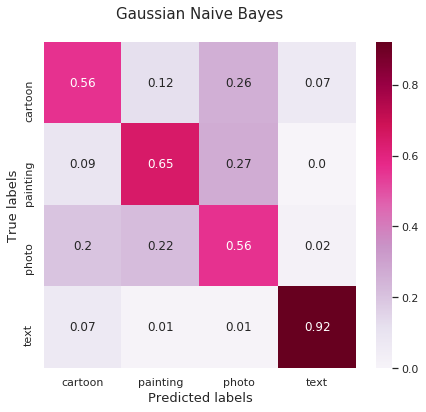

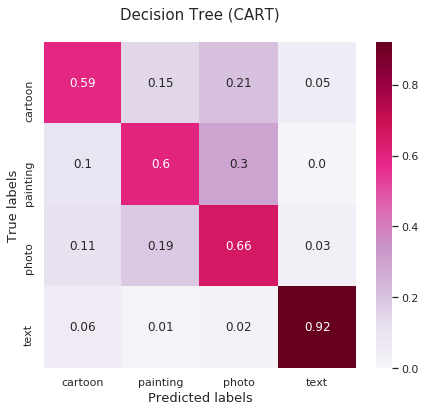

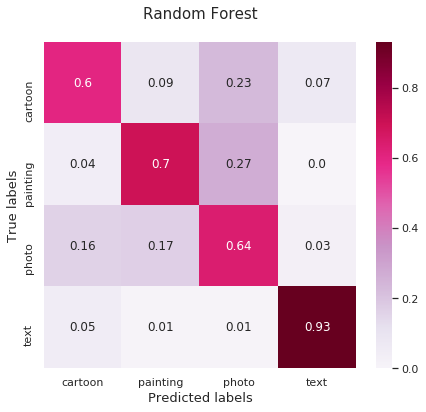

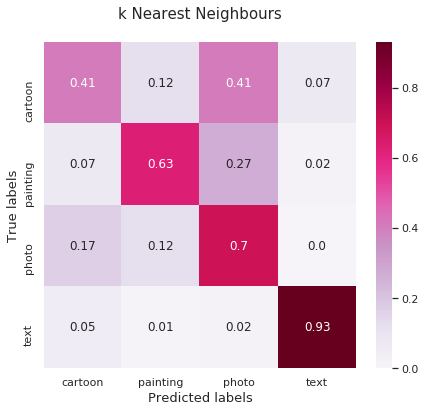

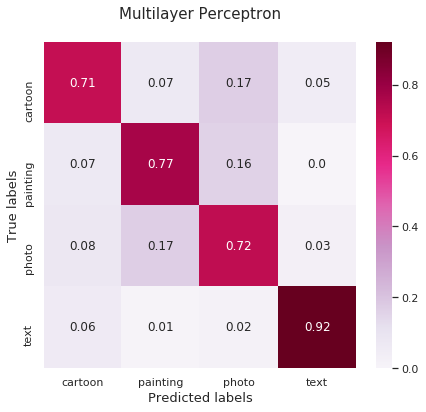

In [44]:
plot_all_cms(cms)

## Wypisanie różnic w klasyfikacji - złych indeksów

In [8]:
pd.set_option('display.max_rows', 150)

In [9]:
def get_differences_for_classifier(df, clf):
    df_filtered = df[['True labels', clf]]
    return df_filtered[df_filtered['True labels'] != df_filtered[clf]]

In [10]:
df_y.columns

Index(['True labels', 'Gaussian Naive Bayes', 'Decision Tree (CART)',
       'Random Forest', 'k Nearest Neighbours', 'Multilayer Perceptron'],
      dtype='object')

In [11]:
df_test = get_differences_for_classifier(df_y, 'Random Forest')
print(df_test[:10].to_latex(index=False, column_format='cc'))

\begin{tabular}{cc}
\toprule
 True labels &  Random Forest \\
\midrule
           0 &              1 \\
           0 &              1 \\
           0 &              2 \\
           0 &              2 \\
           0 &              2 \\
           0 &              2 \\
           0 &              2 \\
           0 &              3 \\
           0 &              3 \\
           0 &              2 \\
\bottomrule
\end{tabular}



## Wizualizacja przykładowego zdjęcia 

In [12]:
def load_image_by_cv2(file_path):
    path = os.path.join(DATA_PATH, file_path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def plot_image(image):
    h, w, _ = image.shape
    plt.figure(figsize=(int(w/100), int(h/100)))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

In [13]:
def create_feature_from_dir(src_path: str, im_type: str, verbose=True):
    labels = os.listdir(src_path)
    labels.sort()
    features = list()
    
    idx = 0
    file_name_list = []
    for i in range(len(labels)):
        label = labels[i]
        if verbose:
            print("\nLabel: {}".format(label))
        label_path = os.path.join(src_path, label)
        label_path = os.path.join(label_path, im_type)
        files = os.listdir(label_path)
        files.sort()
        for file_name in files:
            file_path = os.path.join(label_path, file_name)
            if verbose:
                print(idx, file_name)
            idx += 1
            file_name_list.append(file_path)
    return file_name_list

In [14]:
file_names = create_feature_from_dir(os.path.join(DATA_PATH, 'base_dataset'), 'pics', verbose=False)

In [15]:
# 0	0	2
# 1	0	2
# 2	0	2
# 3	0	2
# 9	0	2
# 16	0	1

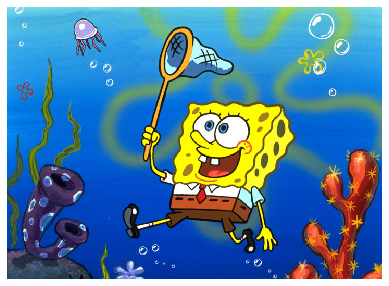

In [16]:
img = load_image_by_cv2(file_names[72])
plot_image(img)

## Analiza wszystkich wyników

In [17]:
feature_count_19 = [3, 1, 1, 1, 8, 32, 478, 18, 400, 60, 15, 5, 11, 43, 489, 521, 509, 541, 63]
feature_count_14 = [3, 8, 32, 478, 18, 400, 60, 11, 43, 489, 521, 509, 541, 63]

In [18]:
def create_table(path, feature_count, filter_cols=[]):
    filenames = glob.glob(f'{DATA_PATH}/{path}/*')
    filenames[:] = [filename for filename in filenames if re.search('pca', filename) is None]
    filenames[:] = [filename for filename in filenames if filename[-8] != "3"]
    filenames[:] = [filename for filename in filenames if re.search('\d{3}', filename[-10:-7]) is None]
    filenames = sorted(filenames)
    
    metrics, metric_names = [], []
    for filename in filenames:
        df_metrics, df_y, confusion_matrices = load_file(filename.split('/')[-1], dir=path)
        metrics.append(df_metrics)
        metric_names.append(filename.split('/')[-1][17:-7])

    metric_names = [mn.replace('_', ' ') for mn in metric_names]
    
    acc = []
    for m in metrics:
        acc.append(m['Accuracy'].values)
    
    tuples = list(zip(metric_names, feature_count))
    multiindex = pd.MultiIndex.from_tuples(tuples, names=['feature name', 'no of features'])
    
    df = pd.DataFrame(np.array(acc).T, columns=multiindex)
    if len(filter_cols) > 0:
        df = df[df.columns[filter_cols]]
    df = df.set_index(metrics[0]['Classifier'], append=True)    
    df = df.droplevel(0)

    df_style = df.style.apply(bold_max).apply(bold_max, axis=1).apply(highlight_max).apply(highlight_max_clf, axis=1)
    return df_style

In [19]:
best_columns = [8, 6, 13, 14, 15, 16, 17, 18]
best_of_14_columns = [5, 3, 8, 9, 10, 11, 12, 13]
# pd.set_option('display.column_space', 5)
# pd.set_option('display.max_colwidth', 3)

In [20]:
def create_table_only(path, feature_count, filter_cols=[], less_features=False):
    filenames = glob.glob(f'{DATA_PATH}/{path}/*')
    filenames[:] = [filename for filename in filenames if re.search('pca', filename) is None]
    filenames[:] = [filename for filename in filenames if filename[-8] != "3"]
    filenames[:] = [filename for filename in filenames if re.search('\d{3}', filename[-10:-7]) is None]
    filenames = sorted(filenames)
    
    metrics, metric_names = [], []
    for filename in filenames:
        df_metrics, df_y, confusion_matrices = load_file(filename.split('/')[-1], dir=path)
        metrics.append(df_metrics)
        metric_names.append(filename.split('/')[-1][17:-7])

#     metric_names = [mn.replace('_', ' ') for mn in metric_names]
    metric_names = ['bilateral filter', 'bilateral filter h', 'bilateral filter color-diff', 'bilateral filter #color-diff', 'color count edges detect', 'gabor filter', 'hsv analyser', 'hsv analyser hsv var', 'hsv analyser sv-dist', 'hsv analyser s-dist', 'kmeans hsv', 'kmeans mean', 'scalar', 'scalar gabor', 'scalar hsv', 'scalar hsv gabor', 'scalar hsv kmeans', 'scalar hsv kmeans gabor', 'scalar kmeans gabor']
    if less_features:
        metric_names = ['bilateral filter', 'color counter edges detect', 'gabor filter', 'hsv analyser', 'hsv analyser hsv var', 'hsv analyser sv-dist', 'hsv analyser s-dist','scalar', 'scalar gabor', 'scalar hsv', 'scalar hsv gabor', 'scalar hsv kmeans', 'scalar hsv kmeans gabor', 'scalar kmeans gabor']
        
    acc = []
    for m in metrics:
        acc.append(m['Accuracy'].values)
    
    tuples = list(zip(metric_names, feature_count))
    multiindex = pd.MultiIndex.from_tuples(tuples, names=['feature name', '#features'])
    
    df = pd.DataFrame(np.array(acc).T, columns=multiindex)
    if len(filter_cols) > 0:
        df = df[df.columns[filter_cols]]
                
    df = df.set_index(metrics[0]['Classifier'], append=True)
    df = df.droplevel(0)
    df = df.rename(index={'Gaussian Naive Bayes': 'Naive Bayes', 
                          'Decision Tree (CART)': 'Decision Tree', 
                          'k Nearest Neighbours': 'kNN',
                          'Multilayer Perceptron': 'MLP'})
    return df
    

def color_table(df):
    df_style = df.style.apply(bold_max).apply(bold_max, axis=1).apply(highlight_max).apply(highlight_max_clf, axis=1)
    return df_style

In [21]:
def generate_latex_table(path, feature_count, filter_cols=[], less_features=False):
    df = create_table_only(path, feature_count, filter_cols, less_features)
    
    vals = df.T.values.astype(float)
    clfs_best, clfs_idxs = np.around(np.max(vals, axis=0), decimals=2), np.argmax(vals, axis=0)
    feature_best = np.around(np.max(vals, axis=1), decimals=2)
    
    latex_txt = df.T.to_latex(bold_rows=True).split('\n')

    latex_txt[0] = '\\begin{tabular}{p{0.28\\textwidth}p{0.1\\textwidth}*{5}{>{\centering\\arraybackslash}p{0.09\\textwidth}}}'
    latex_txt[2] = '                    & \\textbf{Classifier} & \\textbf{Naive Bayes} & \\textbf{Decision Tree} & \\textbf{Random Forest} & \\textbf{   kNN} & \\textbf{   MLP}\\\\'

    for i, best_val in enumerate(feature_best):
        l = latex_txt[i+5]
        idx = l.find(str(best_val))
        latex_txt[i+5] = l[:idx] + '\\cellcolor{FeatureColor}\\textbf{' + l[idx:idx+5] + '} ' + l[idx+5:]
        
    for i, best_val in enumerate(clfs_best):
        l = latex_txt[clfs_idxs[i] + 5]
        idx = l.find(str(best_val))
        if l[idx-1] == '{':
            latex_txt[clfs_idxs[i]+5] = l.replace('FeatureColor', 'ClfColor')
        else:
            latex_txt[clfs_idxs[i]+5] = l[:idx] + '\\cellcolor{ClfColor}\\textbf{' + l[idx:idx+5] + '} ' + l[idx+5:]
            
            
    latex_txt.insert(0, '\\begin{table}[h]')
    latex_txt.insert(1, '\\centering')
    latex_txt.insert(-1, '\\caption{\\textcolor{red}{\\textbf{TODO}} (' + path.replace("_", "-") + ')}')
    latex_txt.insert(-1, '\\end{table}')  
    
    print('\n'.join(latex_txt))

### Tabelki

In [22]:
path = 'results/metrics/pics'
create_table(path, feature_count_19, filter_cols=best_columns)

feature name,hsv analyser sat value distribution,hsv analyser,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,400,478,43,489,521,509,541,63
Classifier,,,,,,,,
Gaussian Naive Bayes,71.02,71.88,71.02,73.86,70.45,74.43,70.17,70.17
Decision Tree (CART),59.94,67.05,71.88,66.48,67.9,66.19,68.18,72.16
Random Forest,73.3,75.57,76.7,75.28,75.28,76.14,77.84,76.42
k Nearest Neighbours,62.5,63.35,55.97,62.5,55.97,63.07,55.97,55.97
Multilayer Perceptron,66.48,70.45,67.33,78.12,66.48,73.58,67.61,66.76


In [23]:
path = 'results/metrics/memes'
generate_latex_table(path, feature_count_19)

\begin{table}[h]
\centering
\begin{tabular}{p{0.28\textwidth}p{0.1\textwidth}*{5}{>{\centering\arraybackslash}p{0.09\textwidth}}}
\toprule
                    & \textbf{Classifier} & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{feature name} & \textbf{\#features} &             &               &               &        &        \\
\midrule
\textbf{bilateral filter} & \textbf{3  } &       58.95 &         60.33 &         \cellcolor{FeatureColor}\textbf{60.88}  &  51.24 &  55.37 \\
\textbf{bilateral filter h} & \textbf{1  } &       34.16 &         \cellcolor{FeatureColor}\textbf{41.05}  &         33.06 &  34.99 &  34.44 \\
\textbf{bilateral filter color-diff} & \textbf{1  } &       50.69 &         50.41 &         47.66 &  51.52 &  \cellcolor{FeatureColor}\textbf{54.55}  \\
\textbf{bilateral filter \#color-diff} & \textbf{1  } &       47.66 &         \cellcolor{FeatureColor}\textbf{49.59}  &         41.87 &   44.9 &  47.

In [24]:
path = 'results/metrics/pics'
create_table(path, feature_count_19)

feature name,bilateral filter,bilateral filter h from hsv differences,bilateral filter mean color diffs,bilateral filter n color diff,color counter edges detector,gabor filter,hsv analyser,hsv analyser hsv var,hsv analyser sat value distribution,hsv analyser saturation distribution,kmeans hsv,kmeans mean,scalar,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,3,1,1,1,8,32,478,18,400,60,15,5,11,43,489,521,509,541,63
Classifier,,,,,,,,,,,,,,,,,,,
Gaussian Naive Bayes,64.2,42.33,60.8,45.45,55.68,66.76,71.88,59.09,71.02,65.62,55.11,55.11,65.62,71.02,73.86,70.45,74.43,70.17,70.17
Decision Tree (CART),65.62,49.43,62.22,50.57,54.83,64.77,67.05,67.61,59.94,62.78,46.31,55.4,67.05,71.88,66.48,67.9,66.19,68.18,72.16
Random Forest,66.48,38.07,55.4,36.36,61.65,67.33,75.57,69.32,73.3,66.19,54.26,49.43,74.43,76.7,75.28,75.28,76.14,77.84,76.42
k Nearest Neighbours,57.95,42.05,55.4,38.07,55.11,55.97,63.35,63.92,62.5,62.78,50.85,52.84,57.95,55.97,62.5,55.97,63.07,55.97,55.97
Multilayer Perceptron,57.39,44.89,49.43,46.59,59.09,61.93,70.45,57.1,66.48,68.75,56.82,55.68,60.23,67.33,78.12,66.48,73.58,67.61,66.76


In [25]:
path = 'results/metrics/memes'
create_table(path, feature_count_19)

feature name,bilateral filter,bilateral filter h from hsv differences,bilateral filter mean color diffs,bilateral filter n color diff,color counter edges detector,gabor filter,hsv analyser,hsv analyser hsv var,hsv analyser sat value distribution,hsv analyser saturation distribution,kmeans hsv,kmeans mean,scalar,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,3,1,1,1,8,32,478,18,400,60,15,5,11,43,489,521,509,541,63
Classifier,,,,,,,,,,,,,,,,,,,
Gaussian Naive Bayes,58.95,34.16,50.69,47.66,54.82,64.46,65.29,50.14,65.01,61.98,50.69,51.24,62.53,64.46,69.15,65.29,68.6,65.01,66.12
Decision Tree (CART),60.33,41.05,50.41,49.59,56.47,57.3,60.06,59.23,59.5,52.07,47.93,48.21,60.33,68.6,64.46,66.39,63.91,66.39,68.87
Random Forest,60.88,33.06,47.66,41.87,60.33,63.64,69.7,69.97,73.28,68.04,52.89,50.69,70.8,68.87,72.18,76.03,74.38,76.31,68.04
k Nearest Neighbours,51.24,34.99,51.52,44.9,60.88,54.82,63.09,54.55,62.53,60.06,50.69,49.31,53.99,54.82,57.02,54.82,55.92,55.1,54.82
Multilayer Perceptron,55.37,34.44,54.55,47.38,63.09,55.92,70.52,46.56,69.42,67.77,48.21,50.41,58.68,57.85,72.45,55.65,71.35,59.78,57.3


In [26]:
path = 'results/metrics/memes'
create_table(path, feature_count_19, filter_cols=best_columns)

feature name,hsv analyser sat value distribution,hsv analyser,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,400,478,43,489,521,509,541,63
Classifier,,,,,,,,
Gaussian Naive Bayes,65.01,65.29,64.46,69.15,65.29,68.6,65.01,66.12
Decision Tree (CART),59.5,60.06,68.6,64.46,66.39,63.91,66.39,68.87
Random Forest,73.28,69.7,68.87,72.18,76.03,74.38,76.31,68.04
k Nearest Neighbours,62.53,63.09,54.82,57.02,54.82,55.92,55.1,54.82
Multilayer Perceptron,69.42,70.52,57.85,72.45,55.65,71.35,59.78,57.3


In [27]:
path = 'results/metrics/pics_stand'
create_table(path, feature_count_19, filter_cols=best_columns)

feature name,hsv analyser sat value distribution,hsv analyser,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,400,478,43,489,521,509,541,63
Classifier,,,,,,,,
Gaussian Naive Bayes,71.02,71.88,72.16,71.59,70.45,70.74,71.02,73.01
Decision Tree (CART),59.38,67.05,72.44,66.48,67.9,66.48,68.18,72.73
Random Forest,70.74,74.15,79.26,78.12,78.69,78.41,77.56,75.85
k Nearest Neighbours,57.1,61.08,76.42,62.78,64.2,63.92,65.06,72.73
Multilayer Perceptron,67.33,71.31,78.12,70.74,76.14,72.16,76.99,78.12


In [29]:
path = 'results/metrics/memes_stand'
generate_latex_table(path, feature_count_19, filter_cols=best_columns)

\begin{table}[h]
\centering
\begin{tabular}{p{0.28\textwidth}p{0.1\textwidth}*{5}{>{\centering\arraybackslash}p{0.09\textwidth}}}
\toprule
                    & \textbf{Classifier} & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{feature name} & \textbf{\#features} &             &               &               &        &        \\
\midrule
\textbf{hsv analyser sv-dist} & \textbf{400} &       65.56 &          59.5 &         68.87 &  64.46 &  \cellcolor{FeatureColor}\textbf{72.18}  \\
\textbf{hsv analyser} & \textbf{478} &       65.56 &         60.06 &         68.87 &  66.39 &  \cellcolor{FeatureColor}\textbf{71.07}  \\
\textbf{scalar gabor} & \textbf{43 } &       65.56 &         68.32 &          71.9 &  66.94 &  \cellcolor{FeatureColor}\textbf{77.41}  \\
\textbf{scalar hsv} & \textbf{489} &       65.56 &         64.74 &         \cellcolor{FeatureColor}\textbf{72.73}  &  63.91 &   71.9 \\
\textbf{scalar hsv gabor} & \t

In [30]:
path = 'results/metrics/memes_stand'
create_table(path, feature_count_19, filter_cols=best_columns)

feature name,hsv analyser sat value distribution,hsv analyser,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
no of features,400,478,43,489,521,509,541,63
Classifier,,,,,,,,
Gaussian Naive Bayes,65.56,65.56,65.56,65.56,65.84,65.56,66.12,68.32
Decision Tree (CART),59.5,60.06,68.32,64.74,66.39,64.74,66.39,68.6
Random Forest,68.87,68.87,71.9,72.73,76.58,73.28,77.96,69.97
k Nearest Neighbours,64.46,66.39,66.94,63.91,66.67,66.94,66.94,69.97
Multilayer Perceptron,72.18,71.07,77.41,71.9,73,75.76,74.1,77.69


In [31]:
best_of_14_columns = [5, 3, 8, 9, 10, 11, 12, 13]

In [32]:
path = 'results/metrics/pics_one_vs_rest'
df = create_table(path, feature_count_14)


In [40]:
path = 'results/metrics/memes_stand_one_vs_rest'
generate_latex_table(path, feature_count_14, filter_cols=best_of_14_columns, less_features=True)

\begin{table}[h]
\centering
\begin{tabular}{p{0.28\textwidth}p{0.1\textwidth}*{5}{>{\centering\arraybackslash}p{0.09\textwidth}}}
\toprule
                    & \textbf{Classifier} & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{feature name} & \textbf{\#features} &             &               &               &        &        \\
\midrule
\textbf{hsv analyser sv-dist} & \textbf{400} &       65.29 &         69.15 &         \cellcolor{FeatureColor}\textbf{71.35}  &  62.81 &  70.52 \\
\textbf{hsv analyser} & \textbf{478} &        68.6 &         68.04 &            73 &  63.91 &   70.8 \\cellcolor{FeatureColor}\textbf{} tbf{hsv analyser} & \textbf{478} &        68.6 &         68.04 &            73 &  63.91 &   70.8 \\
\textbf{scalar gabor} & \textbf{43 } &       68.32 &         \cellcolor{ClfColor}\textbf{70.52}  &            73 &  68.32 &  \cellcolor{ClfColor}\textbf{78.51}  \\
\textbf{scalar hsv} & \textbf{489} &      

In [19]:
path = 'results/metrics/pics_stand_one_vs_rest'
create_table(path, feature_count_14, filter_cols=best_of_14_columns)

,feature name,hsv analyser sat value distribution,hsv analyser,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
,no of features,400,478,43,489,521,509,541,53
,Classifier,,,,,,,,
0,Gaussian Naive Bayes,66.19,66.76,75,66.48,65.91,66.76,66.19,73.3
1,Decision Tree (CART),64.2,73.3,74.72,72.16,75.57,72.44,75,76.14
2,Random Forest,74.72,74.72,79.83,77.56,77.84,74.15,81.53,77.27
3,k Nearest Neighbours,57.1,60.8,75.85,61.93,62.78,62.5,63.35,72.16
4,Multilayer Perceptron,65.91,70.74,79.55,73.01,76.42,71.88,75.28,79.55


In [20]:
path = 'results/metrics/memes_one_vs_rest'
create_table(path, feature_count_14)

,feature name,bilateral filter,color counter edges detector,gabor filter,hsv analyser,hsv analyser hsv var,hsv analyser sat value distribution,hsv analyser saturation distribution,scalar,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
,no of features,3,8,32,478,18,400,60,11,43,489,521,509,541,53
,Classifier,,,,,,,,,,,,,,
0,Gaussian Naive Bayes,59.78,56.2,63.64,66.94,52.34,64.46,61.43,62.26,63.91,63.91,66.12,64.19,65.29,65.29
1,Decision Tree (CART),61.98,61.16,63.36,67.49,66.39,68.32,61.16,63.09,70.52,69.42,69.97,68.04,68.87,69.97
2,Random Forest,61.98,63.91,63.91,72.73,69.15,69.15,70.52,70.52,72.73,75.76,75.48,74.38,75.21,74.38
3,k Nearest Neighbours,48.76,61.43,55.65,60.33,54.55,62.81,58.13,50.96,55.65,55.65,55.65,49.86,55.92,55.65
4,Multilayer Perceptron,49.04,58.95,53.17,69.15,41.32,69.42,68.32,60.06,56.47,73,56.75,72.45,60.61,54.27


In [21]:
path = 'results/metrics/memes_stand_one_vs_rest'
create_table(path, feature_count_14)

,feature name,bilateral filter,color counter edges detector,gabor filter,hsv analyser,hsv analyser hsv var,hsv analyser sat value distribution,hsv analyser saturation distribution,scalar,scalar gabor,scalar hsv,scalar hsv gabor,scalar hsv kmeans,scalar hsv kmeans gabor,scalar kmeans gabor
,no of features,3,8,32,478,18,400,60,11,43,489,521,509,541,53
,Classifier,,,,,,,,,,,,,,
0,Gaussian Naive Bayes,59.78,56.2,63.64,68.6,46.28,65.29,61.43,62.26,68.32,68.6,68.32,68.32,67.77,69.42
1,Decision Tree (CART),61.98,61.43,63.09,68.04,69.15,69.15,61.98,62.81,70.52,69.42,68.87,69.7,69.97,70.25
2,Random Forest,61.16,60.88,63.91,73,71.07,71.35,69.7,69.7,73,75.48,75.48,74.1,75.48,75.21
3,k Nearest Neighbours,59.78,59.23,65.01,63.91,63.91,62.81,64.19,68.04,68.32,62.53,63.64,64.46,65.01,68.87
4,Multilayer Perceptron,65.29,67.22,71.07,70.8,70.25,70.52,66.67,75.48,78.51,73.55,73.28,75.76,74.38,77.41


## Wykresik porównawczy dla najlepszych wyników

In [131]:
suffixes_to_compare = ['', 'stand', 'one_vs_rest', 'stand_one_vs_rest']  # must match directory names
plot_names = ['normal', 'standarized', 'one vs rest', 'one vs rest + stand']

In [136]:
def get_best_results(suffixes):
    prefixes = ['pics', 'memes']
    
    results = [[], []]
    for i, prefix in enumerate(prefixes):
        for suffix in suffixes:
            path = 'results/metrics/' + prefix + ('_' if len(suffix) > 0 else '') + suffix    
            filenames = glob.glob(f'{DATA_PATH}/{path}/*')
            filenames[:] = [filename for filename in filenames if re.search('pca', filename) is None]
            filenames[:] = [filename for filename in filenames if filename[-8] != "3"]
            filenames[:] = [filename for filename in filenames if re.search('\d{3}', filename[-10:-7]) is None]
            filenames = sorted(filenames)

            metrics = []
            for filename in filenames:
                df_metrics, df_y, confusion_matrices = load_file(filename.split('/')[-1], dir=path)
                metrics.append(df_metrics)

            acc = []
            for m in metrics:
                acc.append(m['Accuracy'].values)
            
            results[i].append(np.max(acc))
    return results

In [139]:
best_results = get_best_results(suffixes_to_compare)
best_results

[[78.12000274658203, 79.26000213623047, 80.97000122070312, 81.52999877929688],
 [76.30999755859375, 77.95999908447266, 75.76000213623047, 78.51000213623047]]

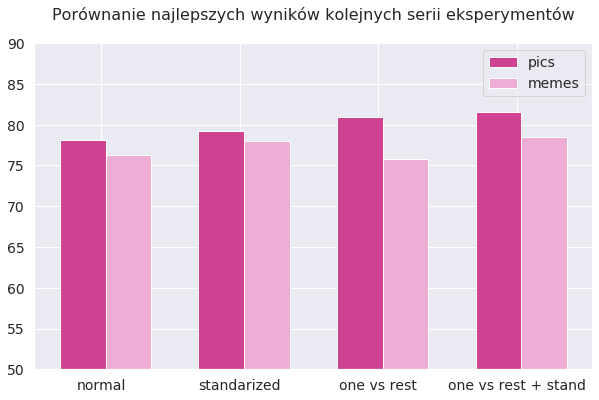

In [194]:
sns.set_palette("PiYG")  # PiYG

plt.figure(figsize=(10, 6))
for i, img_type in enumerate(['pics', 'memes']):
    plt.bar(np.array(range(len(best_results[i]))) + (i-0.4)*0.33, best_results[i], width=0.33, label=img_type)
plt.ylim(50, 90)
plt.xticks(range(len(best_results[i])), plot_names, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Porównanie najlepszych wyników kolejnych serii eksperymentów\n', fontsize=16)
plt.legend(fontsize=14)
plt.show()

## PCA

In [46]:
def create_pca_table(path, feature_count):
    filenames = glob.glob(f'{DATA_PATH}/{path}/*')
    filenames[:] = [filename for filename in filenames if re.search('pca', filename) is not None]
    filenames[:] = [filename for filename in filenames if filename[-8] != "3"]
    filenames[:] = [filename for filename in filenames if re.search('\d{3}', filename[-10:-7]) is None]
    
    filenames = sorted(filenames)
    
    metrics, metric_names = [], []
    for filename in filenames:
        df_metrics, df_y, confusion_matrices = load_file(filename.split('/')[-1], dir=path)
        metrics.append(df_metrics)
        feature_name = filename.split('/')[-1][17:-7]
        metric_names.append(feature_name)

    metric_names = [mn.replace('_', ' ') for mn in metric_names]
    
    acc = []
    for m in metrics:
        acc.append(m['Accuracy'].values)
    
    tuples = list(zip(metric_names, feature_count))
    multiindex = pd.MultiIndex.from_tuples(tuples, names=['feature name', 'no of features'])
    
    df = pd.DataFrame(np.array(acc).T, columns=multiindex)
    cols = ['pca top 5', 'pca top 10', 'pca top 15', 'pca top 25', 'pca top 50']
    df = df[cols]
    df = df.set_index(metrics[0]['Classifier'], append=True)

    df = df.droplevel(0)
    df = df.rename(index={'Gaussian Naive Bayes': 'Naive Bayes', 
                          'Decision Tree (CART)': 'Decision Tree', 
                          'k Nearest Neighbours': 'kNN',
                          'Multilayer Perceptron': 'MLP'})
    
    df = df.style.apply(bold_max).apply(highlight_max).apply(highlight_max_clf)
    return df

In [47]:
def create_pca_table_only(path, feature_count):
    filenames = glob.glob(f'{DATA_PATH}/{path}/*')
    filenames[:] = [filename for filename in filenames if re.search('pca', filename) is not None]
    filenames[:] = [filename for filename in filenames if filename[-8] != "3"]
    filenames[:] = [filename for filename in filenames if re.search('\d{3}', filename[-10:-7]) is None]
    
    filenames = sorted(filenames)
    
    metrics, metric_names = [], []
    for filename in filenames:
        df_metrics, df_y, confusion_matrices = load_file(filename.split('/')[-1], dir=path)
        metrics.append(df_metrics)
        feature_name = filename.split('/')[-1][17:-7]
        metric_names.append(feature_name)

    metric_names = [mn.replace('_', ' ') for mn in metric_names]
    
    acc = []
    for m in metrics:
        acc.append(m['Accuracy'].values)
    
    tuples = list(zip(metric_names, feature_count))
    multiindex = pd.MultiIndex.from_tuples(tuples, names=['feature name', '#features'])
    
    df = pd.DataFrame(np.array(acc).T, columns=multiindex)
    cols = ['pca top 5', 'pca top 10', 'pca top 15', 'pca top 25', 'pca top 50']
    df = df[cols]
    df = df.set_index(metrics[0]['Classifier'], append=True)

    df = df.droplevel(0)
    df = df.rename(index={'Gaussian Naive Bayes': 'Naive Bayes', 
                          'Decision Tree (CART)': 'Decision Tree', 
                          'k Nearest Neighbours': 'kNN',
                          'Multilayer Perceptron': 'MLP'})
    return df

In [48]:
def generate_latex_table_pca(path, feature_count):
    df = create_pca_table_only(path, feature_count)
    
    vals = df.T.values.astype(float)
    feature_best = np.around(np.max(vals, axis=1), decimals=2)
    
    latex_txt = df.T.to_latex(bold_rows=True).split('\n')

    latex_txt[0] = '\\begin{tabular}{p{0.15\\textwidth}p{0.1\\textwidth}*{5}{>{\centering\\arraybackslash}p{0.08\\textwidth}}}'
    latex_txt[2] = '                    & \\textbf{Classifier} & \\textbf{Naive Bayes} & \\textbf{Decision Tree} & \\textbf{Random Forest} & \\textbf{   kNN} & \\textbf{   MLP}\\\\'
    
    for i, best_val in enumerate(feature_best):
        l = latex_txt[i+5]
        idx = l.find(str(best_val))
        latex_txt[i+5] = l[:idx] + '\\cellcolor{FeatureColor}\\textbf{' + l[idx:idx+5] + '} ' + l[idx+5:]    
        
    latex_txt.insert(0, '\\begin{table}[h]')
    latex_txt.insert(1, '\\centering')
    latex_txt.insert(-1, '\\caption{\\textcolor{red}{\\textbf{TODO}} (' + path.replace("_", "-") + ')}')
    latex_txt.insert(-1, '\\end{table}')        
    print('\n'.join(latex_txt))

In [49]:
feature_count_pca = [10, 15, 25, 5, 50]

In [54]:
path = 'results/metrics/pics_one_vs_rest'
create_pca_table(path, feature_count_pca)

feature name,pca top 5,pca top 10,pca top 15,pca top 25,pca top 50
no of features,5,10,15,25,50
Classifier,,,,,
Naive Bayes,57.39,66.76,65.06,67.33,65.62
Decision Tree,65.91,69.32,68.18,69.03,65.62
Random Forest,67.9,73.58,71.88,73.58,75.85
kNN,58.24,56.53,56.82,56.82,56.82
MLP,61.08,69.89,70.74,73.01,70.74


In [58]:
generate_latex_table_pca('results/metrics/memes_one_vs_rest', feature_count_pca)

\begin{table}[h]
\centering
\begin{tabular}{p{0.15\textwidth}p{0.1\textwidth}*{5}{>{\centering\arraybackslash}p{0.08\textwidth}}}
\toprule
                    & \textbf{Classifier} & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{feature name} & \textbf{\#features} &             &               &               &        &        \\
\midrule
\textbf{pca top 5} & \textbf{5 } &       48.48 &         52.34 &         \cellcolor{FeatureColor}\textbf{61.16}  &  53.72 &   55.1 \\
\textbf{pca top 10} & \textbf{10} &       59.78 &         64.46 &          \cellcolor{FeatureColor}\textbf{69.7 } &  55.92 &  65.56 \\
\textbf{pca top 15} & \textbf{15} &       65.29 &         63.36 &          \cellcolor{FeatureColor}\textbf{69.7 } &  55.92 &  65.84 \\
\textbf{pca top 25} & \textbf{25} &       61.98 &         65.84 &         \cellcolor{FeatureColor}\textbf{71.63}  &  55.92 &  63.64 \\
\textbf{pca top 50} & \textbf{50} &       62.26 &

In [59]:
path = 'results/metrics/pics_stand_one_vs_rest'
create_pca_table(path, feature_count_pca)

feature name,pca top 5,pca top 10,pca top 15,pca top 25,pca top 50
no of features,5,10,15,25,50
Classifier,,,,,
Naive Bayes,57.39,66.76,65.06,67.33,66.19
Decision Tree,64.77,69.03,68.75,69.03,66.19
Random Forest,67.05,74.15,72.16,72.73,74.43
kNN,67.33,69.03,65.06,66.19,63.07
MLP,71.02,72.73,73.86,73.01,78.41


In [62]:
generate_latex_table_pca('results/metrics/memes_stand_one_vs_rest', feature_count_pca)

\begin{table}[h]
\centering
\begin{tabular}{p{0.15\textwidth}p{0.1\textwidth}*{5}{>{\centering\arraybackslash}p{0.08\textwidth}}}
\toprule
                    & \textbf{Classifier} & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{feature name} & \textbf{\#features} &             &               &               &        &        \\
\midrule
\textbf{pca top 5} & \textbf{5 } &       48.48 &         52.07 &          58.4 &   55.1 &  \cellcolor{FeatureColor}\textbf{59.78}  \\
\textbf{pca top 10} & \textbf{10} &       59.78 &         64.19 &         \cellcolor{FeatureColor}\textbf{69.42}  &  67.77 &   68.6 \\
\textbf{pca top 15} & \textbf{15} &       65.29 &         63.64 &         69.15 &  \cellcolor{FeatureColor}\textbf{69.97}  &  69.97 \\
\textbf{pca top 25} & \textbf{25} &       62.26 &         64.74 &         64.19 &  64.19 &  \cellcolor{FeatureColor}\textbf{71.63}  \\
\textbf{pca top 50} & \textbf{50} &       65.84 &

In [94]:
path = 'results/metrics/memes_one_vs_rest'
create_pca_table(path, feature_count_pca)

feature name,pca top 5,pca top 10,pca top 15,pca top 25,pca top 50
no of features,5,10,15,25,50
Classifier,,,,,
Naive Bayes,48.48,59.78,65.29,61.98,62.26
Decision Tree,52.34,64.46,63.36,65.84,65.01
Random Forest,61.16,69.7,69.7,71.63,71.63
kNN,53.72,55.92,55.92,55.92,55.92
MLP,55.1,65.56,65.84,63.64,67.49


In [95]:
path = 'results/metrics/memes_stand_one_vs_rest'
create_pca_table(path, feature_count_pca)

,feature name,pca top 5,pca top 10,pca top 15,pca top 25,pca top 50
,no of features,5,10,15,25,50
,Classifier,,,,,
0,Gaussian Naive Bayes,48.48,59.78,65.29,62.26,65.84
1,Decision Tree (CART),52.07,64.19,63.64,64.74,65.01
2,Random Forest,58.4,69.42,69.15,64.19,73.55
3,k Nearest Neighbours,55.1,67.77,69.97,64.19,63.64
4,Multilayer Perceptron,59.78,68.6,69.97,71.63,75.76


## Dependency on size

In [243]:
sns.set_palette("husl")

In [110]:
def load_dep_on_size(directory, filename):
    def bold_max(s):
        values = [False for _ in s.values]
        if s.name != 'Dataset Size':
            max_val = np.max(s.values[s.values < 120])
            values = [True if v == max_val else False for v in s.values]
        return ['font-weight: bold' if v else '' for v in values]

    def highlight_max(s):
        values = [False for _ in s.values]
        if s.name != 'Dataset Size':
            max_val = np.max(s.values[s.values < 120])
            values = [True if v == max_val else False for v in s.values]
        return ['background-color: lightpink' if v else '' for v in values]

    dataset_path = os.path.join(DATA_PATH, f'{directory}/{filename}')
    df = pd.read_csv(dataset_path, index_col=False)
    df = df.groupby(["Dataset Size"]).mean()
    df = df.reset_index()
    
    plt.figure(figsize=(10, 6))
    for column in df.columns[1:]:
        plt.plot(df["Dataset Size"], df[column], 'o-', label=column, linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Zależność f1 score od rozmiaru zbioru danych\n', fontsize=16)
    plt.legend(fontsize=14)
    plt.show()
    
    df_style = df.style.apply(bold_max).apply(bold_max, axis=1).apply(highlight_max)
    return df_style

In [143]:
def create_dataset_size_table_only(directory, filename):
    dataset_path = os.path.join(DATA_PATH, f'{directory}/{filename}')
    df = pd.read_csv(dataset_path, index_col=False)
    df = df.groupby(["Dataset Size"]).mean()
#     df = df.index.drop_level(0)
    df = df.round(2)

    return df

In [144]:
create_dataset_size_table_only("results/tables/combined", "f1score-scalar_hsv_kmeans_gabor.csv")

,Gaussian Naive Bayes,Decision Tree (CART),Random Forest,k Nearest Neighbours,Multilayer Perceptron
Dataset Size,,,,,
150,56.34,56.48,63.50,52.57,59.43
300,63.43,60.85,71.85,56.47,63.91
450,65.18,63.67,74.48,58.58,65.91
608,65.27,68.31,76.81,58.94,66.66


In [145]:
def generate_latex_table_dataset_size(directory, filename):
    df = create_dataset_size_table_only(directory, filename)
    
    vals = df.values.astype(float)
    feature_best = np.around(np.max(vals, axis=1), decimals=2)
    
    latex_txt = df.to_latex(bold_rows=True).split('\n')

    latex_txt[0] = '\\begin{tabular}{p{0.15\\textwidth}*{5}{>{\centering\\arraybackslash}p{0.08\\textwidth}}}'
    latex_txt[2] = '              & \\textbf{Naive Bayes} & \\textbf{Decision Tree} & \\textbf{Random Forest} & \\textbf{   kNN} & \\textbf{   MLP}\\\\'
    
    for i, best_val in enumerate(feature_best):
        l = latex_txt[i+5]
        idx = l.find(str(best_val))
        latex_txt[i+5] = l[:idx] + '\\cellcolor{FeatureColor}\\textbf{' + l[idx:idx+5] + '} ' + l[idx+5:]    
        
    latex_txt.insert(0, '\\begin{table}[h]')
    latex_txt.insert(1, '\\centering')
    latex_txt.insert(-1, '\\caption{\\textcolor{red}{\\textbf{TODO}} (' + f'{directory}/{filename}'.replace("_", "-") + ')}')
    latex_txt.insert(-1, '\\end{table}')        
    print('\n'.join(latex_txt))

In [146]:
generate_latex_table_dataset_size("results/tables/combined", "f1score-scalar_hsv_kmeans_gabor.csv")

\begin{table}[h]
\centering
\begin{tabular}{p{0.15\textwidth}*{5}{>{\centering\arraybackslash}p{0.08\textwidth}}}
\toprule
              & \textbf{Naive Bayes} & \textbf{Decision Tree} & \textbf{Random Forest} & \textbf{   kNN} & \textbf{   MLP}\\
\textbf{Dataset Size} &                       &                       &                &                       &                        \\
\midrule
\textbf{150         } &                 56.34 &                 56.48 &          \cellcolor{FeatureColor}\textbf{63.50}  &                 52.57 &                  59.43 \\
\textbf{300         } &                 63.43 &                 60.85 &          \cellcolor{FeatureColor}\textbf{71.85}  &                 56.47 &                  63.91 \\
\textbf{450         } &                 65.18 &                 63.67 &          \cellcolor{FeatureColor}\textbf{74.48}  &                 58.58 &                  65.91 \\
\textbf{608         } &                 65.27 &                 68.31 &          \cel

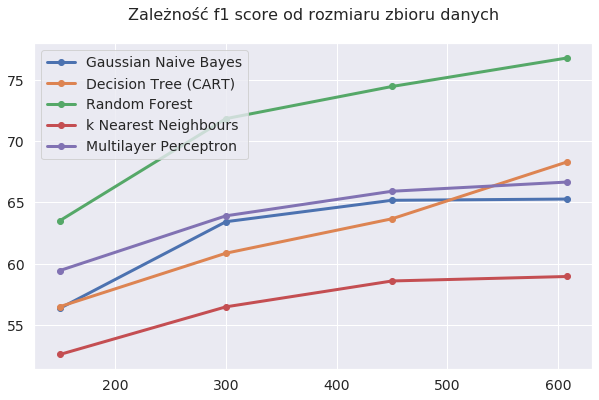

,Dataset Size,Gaussian Naive Bayes,Decision Tree (CART),Random Forest,k Nearest Neighbours,Multilayer Perceptron
0,150,56.34,56.48,63.505,52.57,59.43
1,300,63.425,60.85,71.85,56.465,63.905
2,450,65.175,63.665,74.48,58.58,65.915
3,608,65.275,68.31,76.81,58.945,66.665


In [131]:
load_dep_on_size("results/tables/combined", "f1score-scalar_hsv_kmeans_gabor.csv")

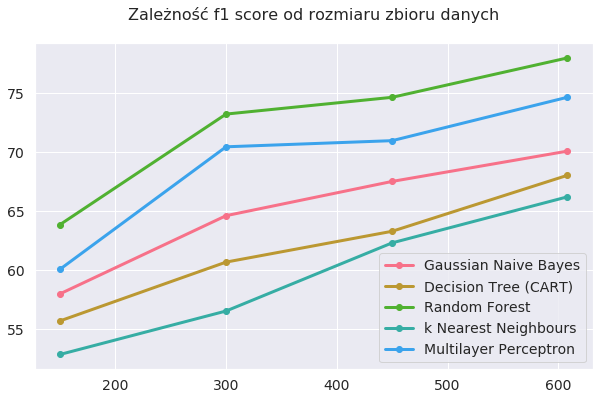

,Dataset Size,Gaussian Naive Bayes,Decision Tree (CART),Random Forest,k Nearest Neighbours,Multilayer Perceptron
0,150,57.99,55.7,63.85,52.86,60.07
1,300,64.61,60.68,73.21,56.54,70.44
2,450,67.51,63.29,74.63,62.31,70.96
3,608,70.07,68.02,77.96,66.2,74.63


In [252]:
load_dep_on_size("results/tables/combined_stand", "f1score-scalar_hsv_kmeans_gabor.csv")

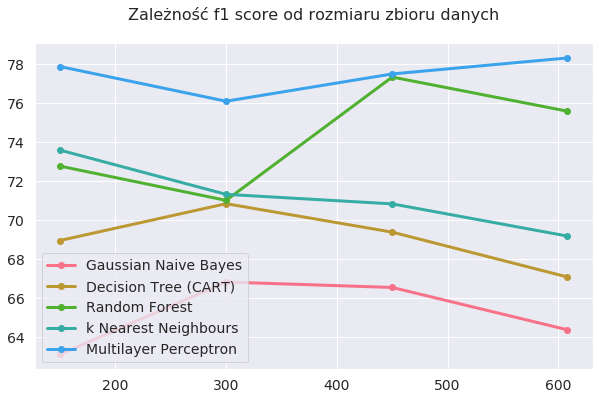

,Dataset Size,Gaussian Naive Bayes,Decision Tree (CART),Random Forest,k Nearest Neighbours,Multilayer Perceptron
0,150,63.11,68.96,72.78,73.6,77.89
1,300,66.83,70.85,71.02,71.33,76.11
2,450,66.55,69.39,77.35,70.84,77.51
3,608,64.38,67.09,75.6,69.19,78.33


In [253]:
load_dep_on_size("results/tables/combined_stand", "f1score-scalar_gabor.csv")

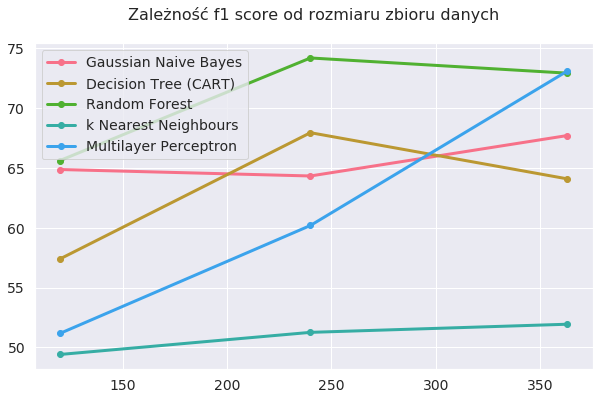

,Dataset Size,Gaussian Naive Bayes,Decision Tree (CART),Random Forest,k Nearest Neighbours,Multilayer Perceptron
0,120,64.87,57.39,65.62,49.4,51.16
1,240,64.33,67.95,74.2,51.25,60.19
2,363,67.71,64.09,72.93,51.93,73.1


In [254]:
url = 'https://python-graph-gallery.com/wp-content/uploads/volcano.csv'
data = pd.read_csv(url)

data